# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [1]:
!git clone -b develop https://github.com/JaneKorelskaya/cvr_course

fatal: destination path 'cvr_course' already exists and is not an empty directory.


In [2]:
cd cvr_course/notebooks

/content/cvr_course/notebooks


In [3]:
import numpy as np
import cv2
import time
import os
import math
import sys
import glob
from matplotlib import pyplot as plt

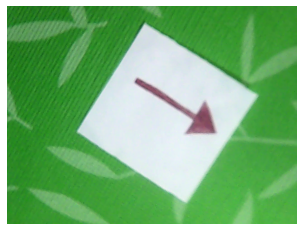

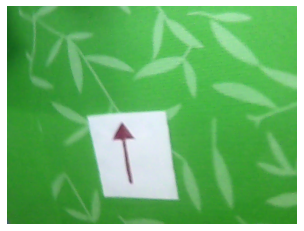

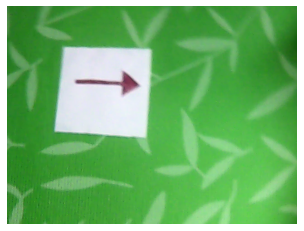

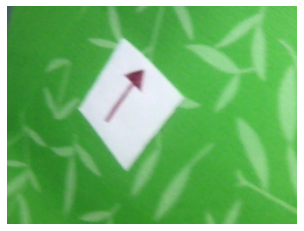

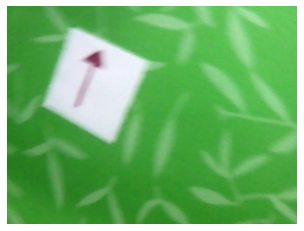

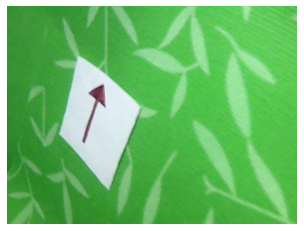

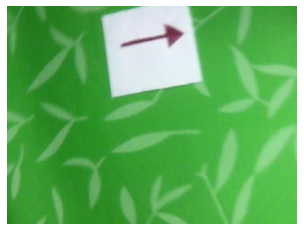

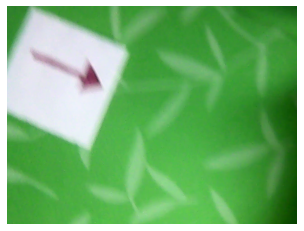

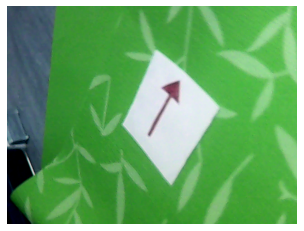

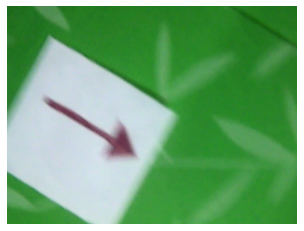

In [4]:
images_data = glob.glob('../data/imgs/arrow/*.png')
images = []
for fname in images_data:
    img = cv2.imread(fname, cv2.IMREAD_COLOR)
    images.append(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Найдем расстояние от камеры до листиков

In [5]:
def find_contour (img, low_th, high_th):
    kernel = np.ones((5, 5), 'uint8')
    img = cv2.dilate(img, kernel)

    img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.inRange(img, low_th, high_th)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.imshow(mask)
    plt.axis('off')
    plt.show()

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]

    approx = cv2.convexHull(cnt)

    epsilon = 0.05 * cv2.arcLength(approx, True)
    approx = cv2.approxPolyDP(approx, epsilon, True)

    return approx

In [6]:
def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)

    contour = find_contour(img, low_th, high_th)
    
    length = cv2.arcLength(contour, True)
    
    print(contour)

    distance = 180.0 * 364 / length
    
    return distance

Image  1


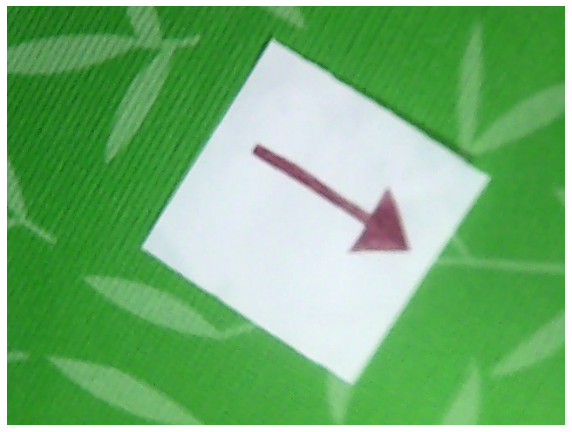

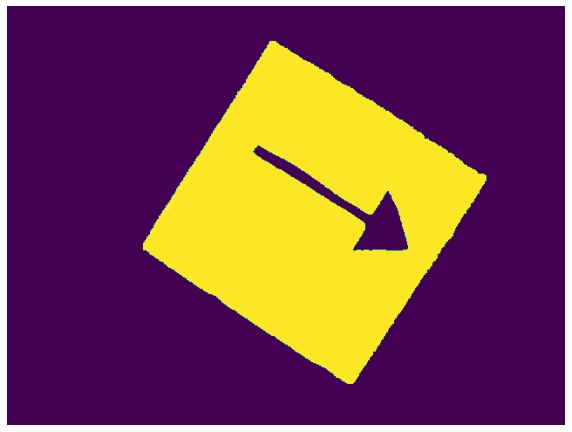

[[[549 194]]

 [[396 432]]

 [[156 279]]

 [[301  40]]]
57.52273530686937
Image  2


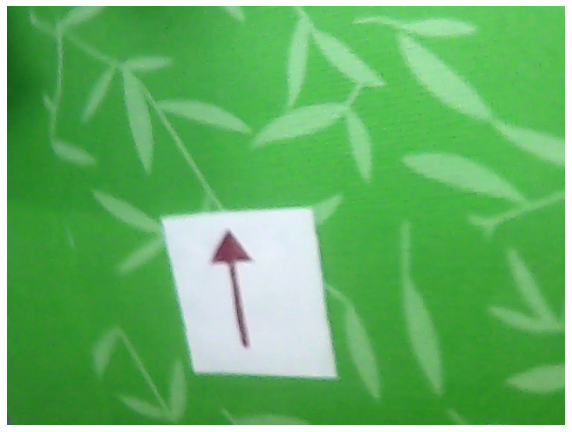

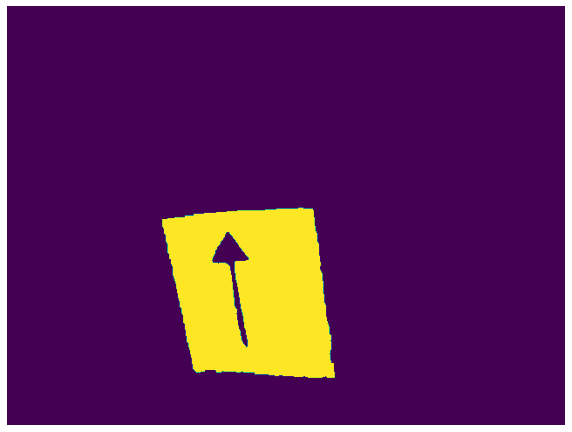

[[[375 425]]

 [[217 419]]

 [[178 244]]

 [[350 232]]]
93.0103846522249
Image  3


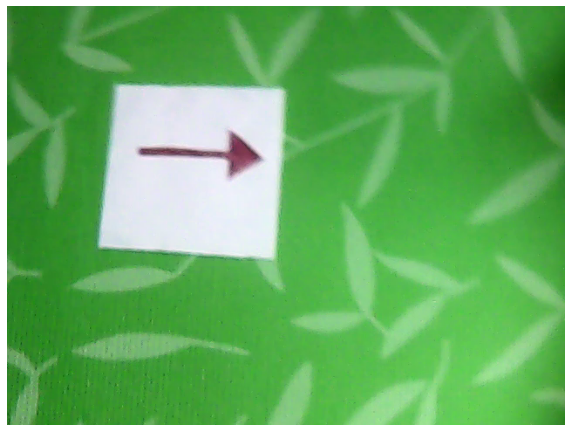

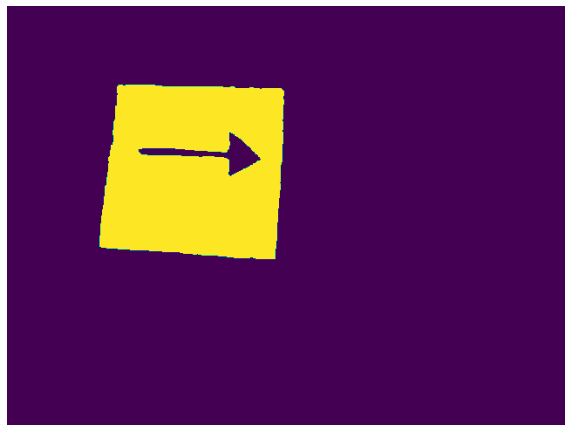

[[[317  97]]

 [[307 289]]

 [[106 275]]

 [[128  90]]]
85.18158900196393
Image  4


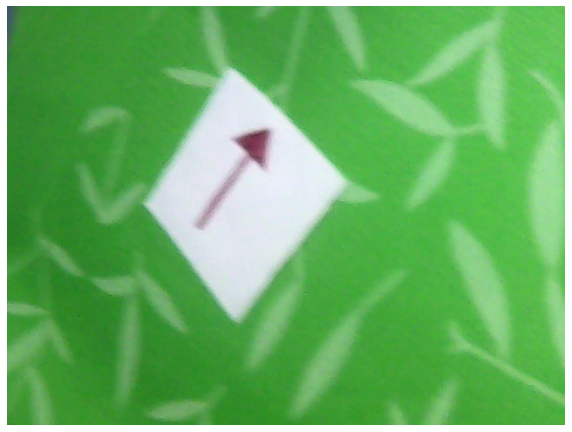

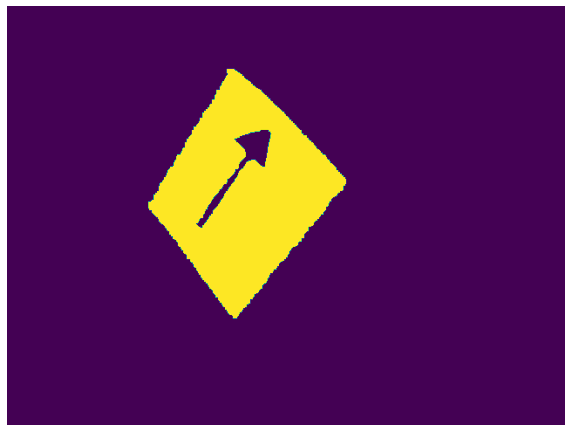

[[[388 198]]

 [[263 357]]

 [[162 231]]

 [[252  72]]]
89.52805727735729
Image  5


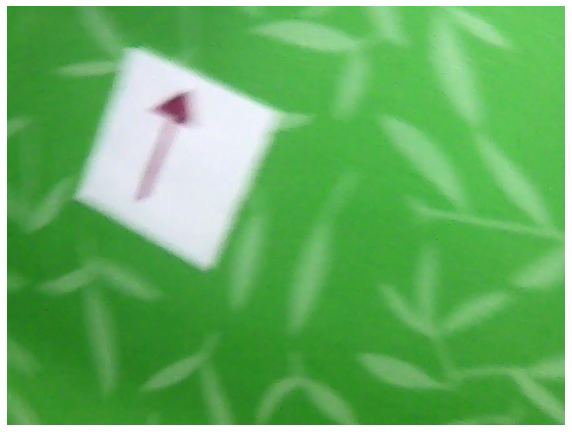

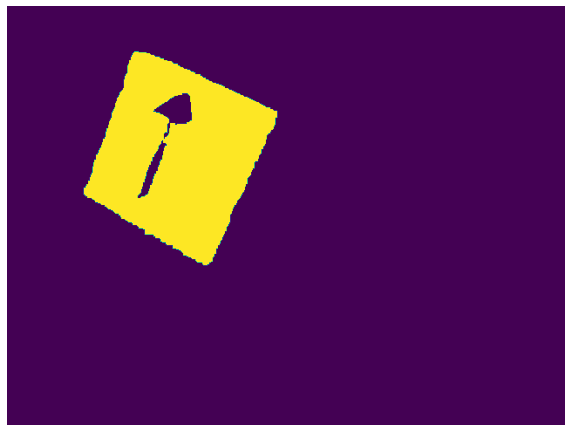

[[[309 120]]

 [[229 296]]

 [[ 88 215]]

 [[146  52]]]
92.86166041002811
Image  6


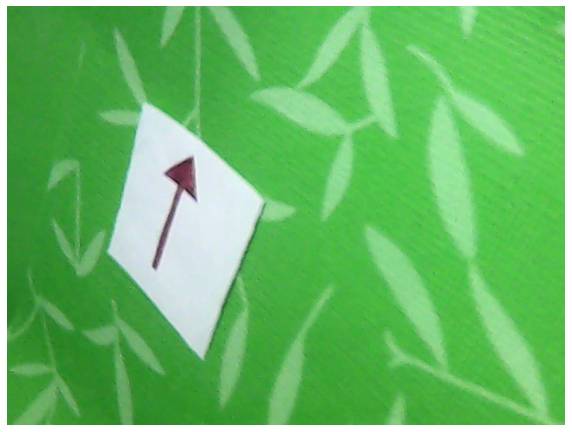

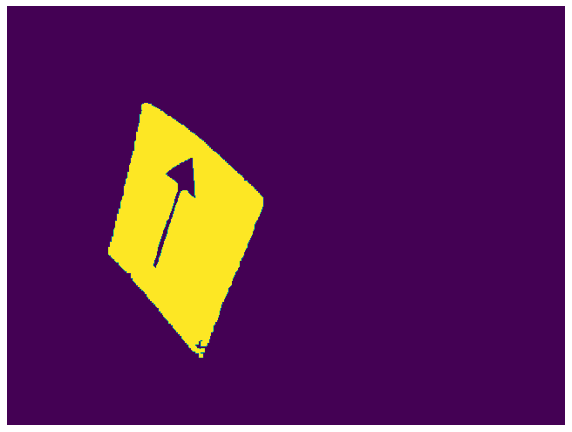

[[[157 111]]

 [[293 219]]

 [[224 402]]

 [[116 284]]]
92.67367135187634
Image  7


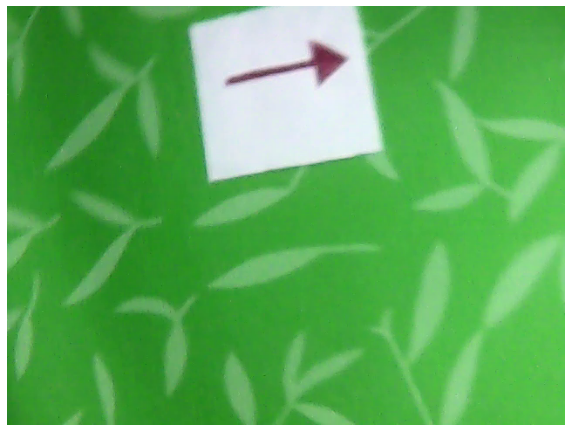

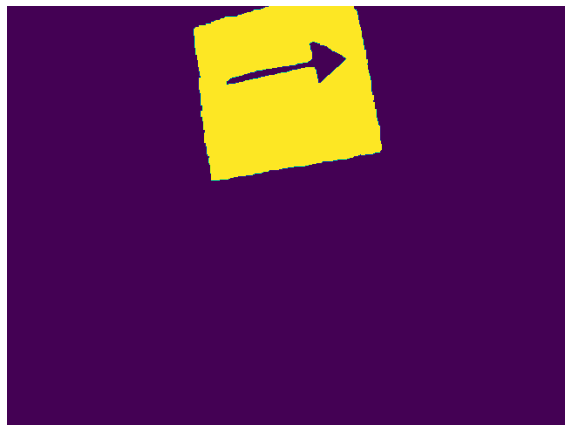

[[[429 164]]

 [[234 199]]

 [[214  26]]

 [[397   0]]]
90.4723790541648
Image  8


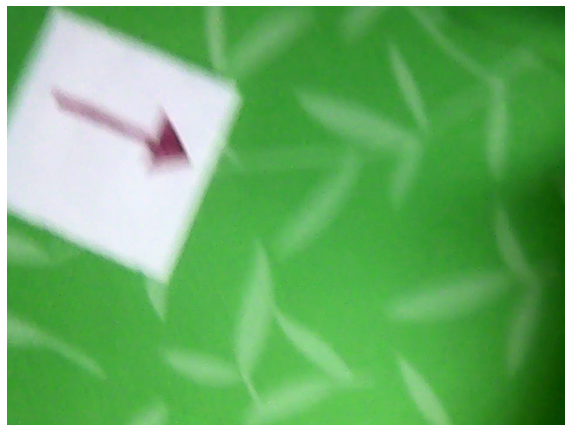

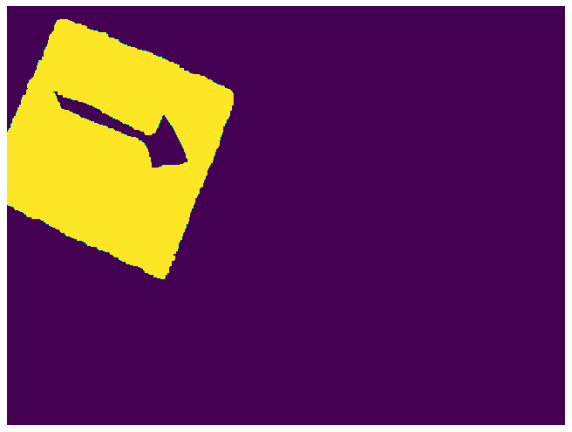

[[[259 100]]

 [[180 312]]

 [[  0 227]]

 [[ 57  16]]]
75.95340879478586
Image  9


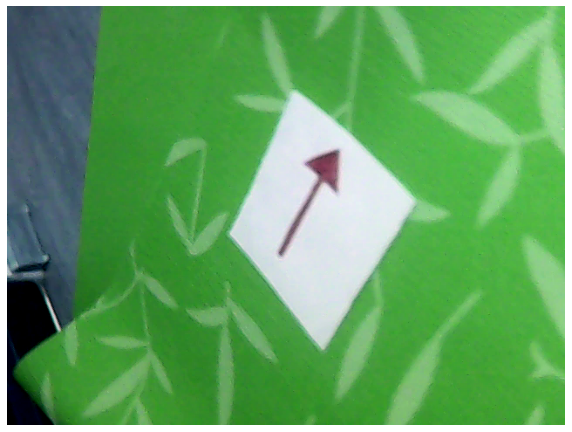

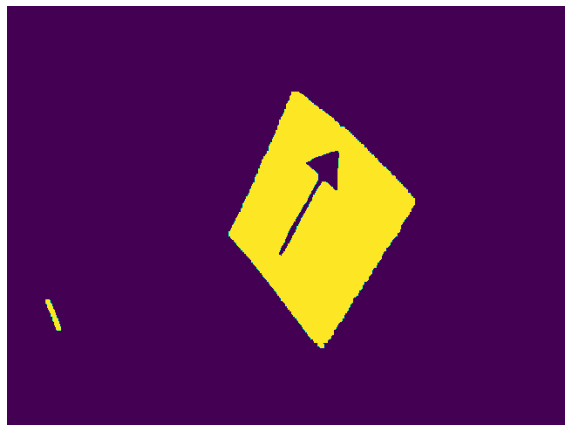

[[[ 61 371]]

 [[ 44 336]]]
841.9396468433578
Image  10


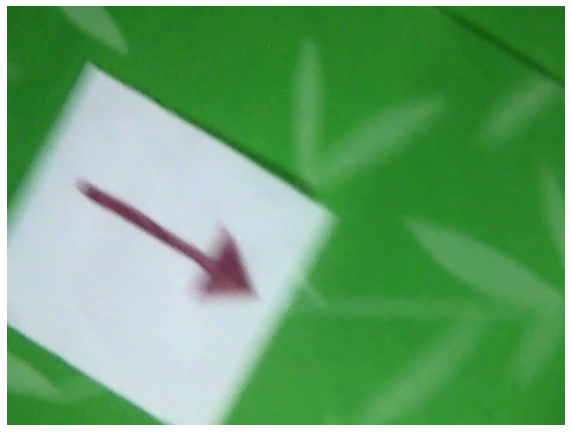

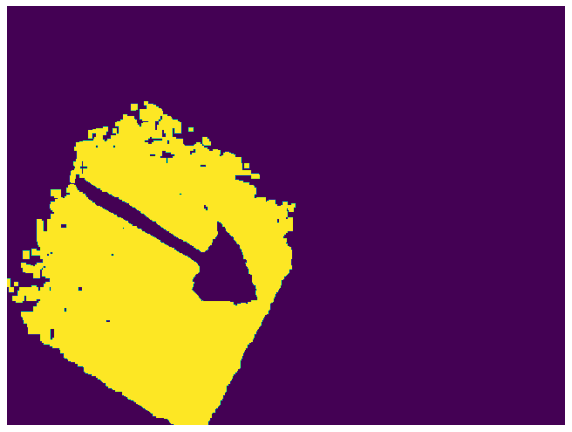

[[[ 12 320]]

 [[  8 320]]

 [[  8 316]]

 [[ 12 316]]]
4095.0


In [7]:
for i in range(len(images)):
    print("Image ", i+1)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.imshow(images[i])
    plt.axis('off')
    plt.show()
    dist = find_distance(images[i])
    print(dist)

Приведем изображение к "виду сверху"

In [8]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [9]:
def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

In [75]:
masks = []
dilated_images = []

low_th  = (200, 200, 200)
high_th = (255, 255, 255)

for img in images:
    kernel = np.ones((5, 5), 'uint8')
    img = cv2.dilate(img, kernel)
    dilated_images.append(img)
    masks.append(cv2.inRange(img, low_th, high_th))

In [76]:
approxes = []
top_arrows = []
for mask in masks:
    #ищем контур поточечно
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    #ищем выпуклую оболочку
    approx = cv2.convexHull(cnt)
    #находим размер сегмента, которым можем пренебречь
    epsilon = 0.05 * cv2.arcLength(approx, True)
    #строим более грубую аппроксимацию
    approx = cv2.approxPolyDP(approx, epsilon, True)

    approxes.append(approx)

In [77]:
for approx, img in zip(approxes, dilated_images):
    top_arrows.append(four_point_transform(img, np.asarray(approx)[:, 0, :]))

Arrow  1


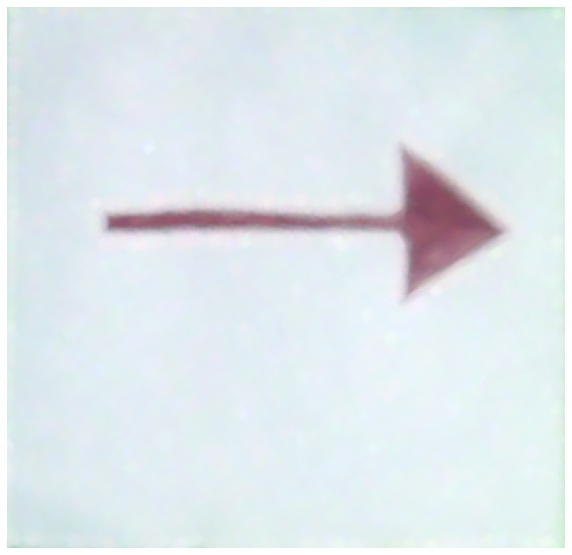

Arrow  2


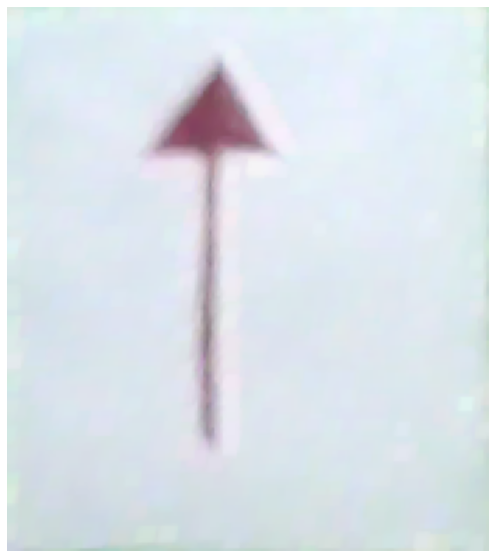

Arrow  3


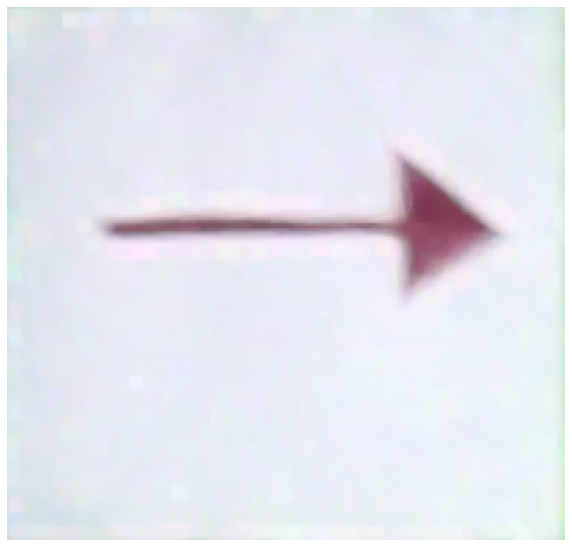

In [78]:
#for i in range(len(top_arrows)):
for i in range(3):
    print("Arrow ", i+1)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.imshow(top_arrows[i])
    plt.axis('off')
    plt.show()

Определение направления стрелки на изображениях "вид сверху"

In [79]:
from random import randrange
from math import pi, fabs, sin, cos
from numpy.linalg import inv

In [80]:
def skeletonize(arrow, lower_thr):
    gray_arrow = cv2.cvtColor(arrow, cv2.COLOR_BGR2GRAY)
    size = np.size(gray_arrow)
    skel = np.zeros(gray_arrow.shape,np.uint8)
    ret,im = cv2.threshold(gray_arrow,lower_thr,255,0)

    USE_OPENCV_CONTRIB = 0 

# Doing skeletonisation
    if USE_OPENCV_CONTRIB:
    # Doing Zhang-Suen skeletonisation (gives better results, but requires opencv-contrib-python package installed)
        skel = cv2.ximgproc.thinning(im)
    else:
    # Doing morphological skeletonisation with barebone OpenCV
        element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
        done = False
        while( not done):
            eroded = cv2.erode(im,element)
            temp = cv2.dilate(eroded,element)
            temp = cv2.subtract(im,temp)
            skel = cv2.bitwise_or(skel,temp)
            im = eroded.copy()

            zeros = size - cv2.countNonZero(im)
            if zeros==size:
                done = True

    return skel

In [81]:
def make_array_for_direction_line(arrow, threshold):
    x_train = []
    y_train = []
    cols_num = arrow.shape[1]
    rows_num = arrow.shape[0]
    for i in range(int(0.1*rows_num), int(0.9*rows_num)):
        for j in range(int(0.1*cols_num), int(0.9*cols_num)):
            if arrow[i][j] > threshold:
                x_train.append(j)
                y_train.append(i)
    return np.array(x_train).reshape(-1, 1), np.array(y_train)

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN

In [83]:
def intersection_point(a1, b1, a2, b2):
    x_common = (b2 - b1) / (a1 - a2)
    y_common = a1 * x_common + b1
    return x_common, y_common

In [84]:
def get_direction_on_top_arrow(top_arrow, skel_thr, eps):
    skel_arrow = skeletonize(top_arrow, skel_thr)

    x_train, y_train = make_array_for_direction_line(skel_arrow, skel_thr)
    points = np.column_stack([x_train, y_train])

    clustering = DBSCAN(eps=eps, min_samples=10).fit(points)
    x_side_1 = []
    x_side_2 = []
    y_side_1 = []
    y_side_2 = []

    for i in range(clustering.labels_.shape[0]):
        if clustering.labels_[i] == 0:
            x_side_1.append(x_train[i])
            y_side_1.append(y_train[i])
        elif clustering.labels_[i] == 1:
            x_side_2.append(x_train[i])
            y_side_2.append(y_train[i])     
    x_side_1 = np.array(x_side_1)
    y_side_1 = np.array(y_side_1)
    x_side_2 = np.array(x_side_2)
    y_side_2 = np.array(y_side_2)

    model_1 = LinearRegression().fit(x_side_1, y_side_1)
    model_2 = LinearRegression().fit(x_side_2, y_side_2)
    y_pred_1 = model_1.predict(x_side_1)
    y_pred_2 = model_2.predict(x_side_2)

    x_end, y_end = intersection_point(model_1.coef_[0], model_1.intercept_, model_2.coef_[0], model_2.intercept_)
    x_start = (np.mean(x_side_1) + np.mean(x_side_2)) / 2
    y_start = (np.mean(y_side_1) + np.mean(y_side_2)) / 2

    #print(x_start, y_start, x_end, y_end)
    if np.abs(x_end - x_start) > np.abs(y_end - y_start):
        if x_end > x_start:
            print("Right")
        else:
            print("Left")
    else:
        if y_end > y_start:
            print("Down")
        else:
            print("Up")
    print("direction")

    plt.plot(x_side_1, y_pred_1)
    plt.plot(x_side_2, y_pred_2)
    plt.scatter(x_end, y_end)
    plt.scatter(x_start, y_start)
    plt.imshow(skel_arrow)

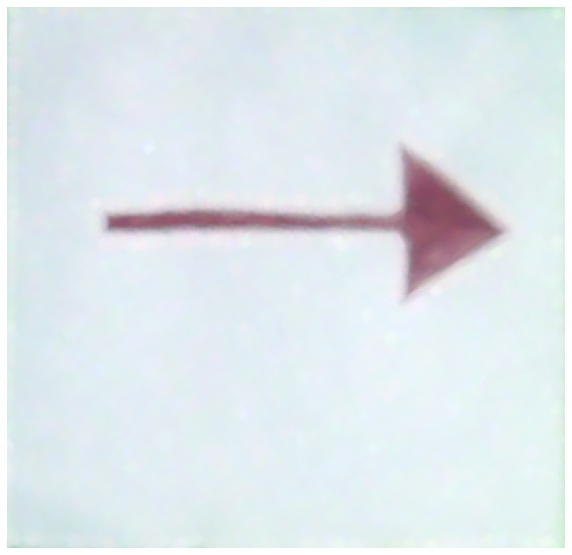

Right
direction


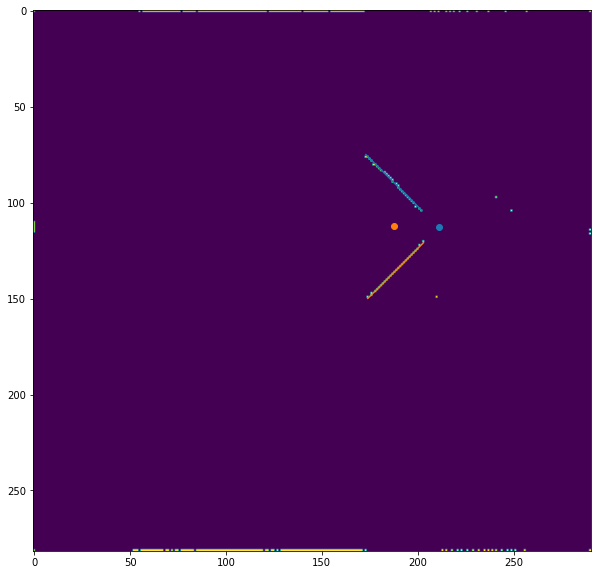

In [85]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(top_arrows[0])
plt.axis('off')
plt.show()
get_direction_on_top_arrow(top_arrows[0], 200, 8)

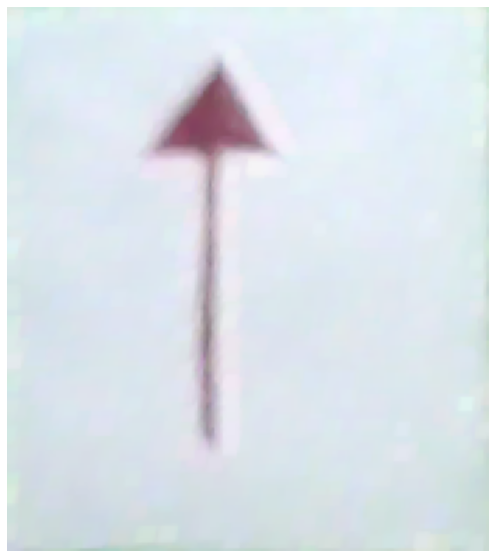

Up
direction


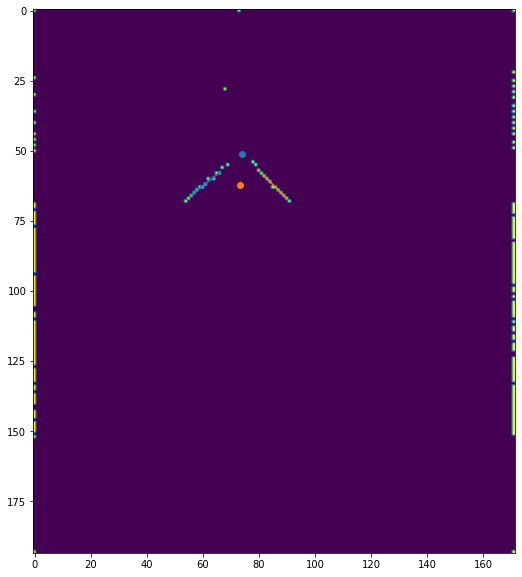

In [86]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(top_arrows[1])
plt.axis('off')
plt.show()
get_direction_on_top_arrow(top_arrows[1], 180, 7)

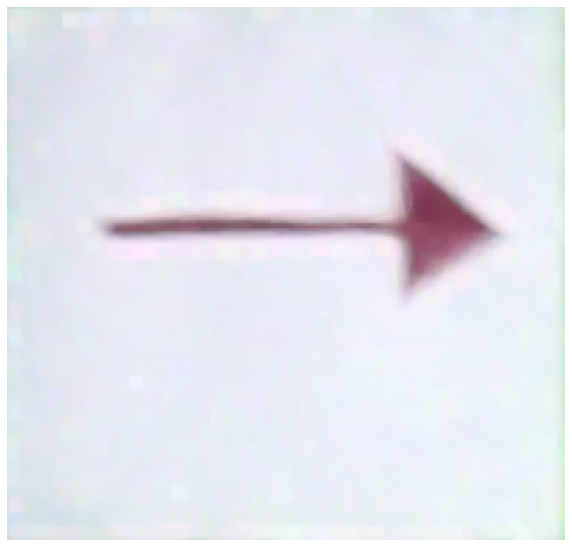

Right
direction


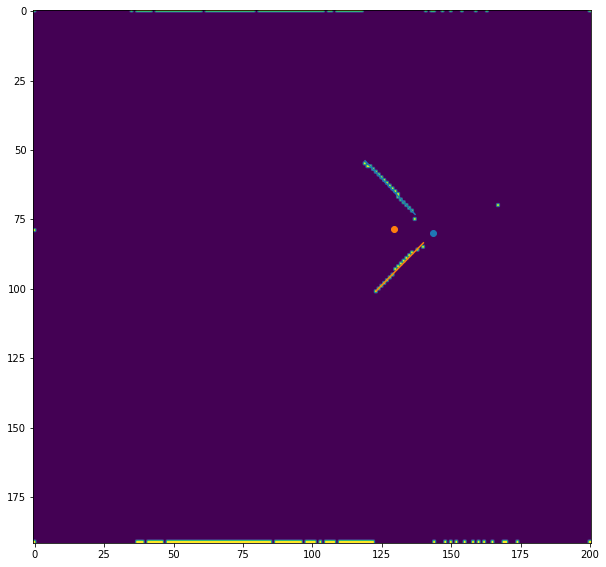

In [87]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(top_arrows[2])
plt.axis('off')
plt.show()
get_direction_on_top_arrow(top_arrows[2], 200, 8)